In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [2]:
CLIENT_ID = 'UOUHP3MTCGTBH0LIOXISERQSLW0Y4IDY3T3AIBQTN3Z0GTR0' # your Foursquare ID
CLIENT_SECRET = '0W3UBB3YVCCQYYDCHA21J2QBNYJBINVNQJ5LNUBTCE5J3NBL' # your Foursquare Secret
ACCESS_TOKEN = 'J3QQOFWWFU2N2ZEB0UOSD2MR3QCSA2KLSVXYDW2K2FTKF3JH' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UOUHP3MTCGTBH0LIOXISERQSLW0Y4IDY3T3AIBQTN3Z0GTR0
CLIENT_SECRET:0W3UBB3YVCCQYYDCHA21J2QBNYJBINVNQJ5LNUBTCE5J3NBL


## Retrieving Foursquare categories information

In [3]:
# create the API request URL
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
    
# make the GET request
results = requests.get(url).json()


In [4]:
a = pd.DataFrame(results["response"]["categories"])
a.head()
ind = a.loc[:,"pluralName"]=="Food"
test = np.sum(ind.index.to_numpy()*ind.to_numpy())
test
b = pd.DataFrame(a.loc[test,"categories"])
restaurant_category_list = b["name"]

## Derive existing restaurant information in different neighbourhood


In [5]:
# Read the suburbs coordinates.
df = pd.read_csv("Toronto_neighbourhood.csv")


In [6]:
def getNearbyVenues(names, latitudes, longitudes, section="food", radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            section, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Define search radius
- Considering that the size of Toronto is 630 square meters and we are examing 108 areas here, Two longest distances from north to South and from East to West are 21 and 43 km respectively.

- Therefore, each area would be about 6 square km and consider the length and width ratio mentioned above (2:1), we can say 
considering that the cover range would be a about 4*1.5.
- so we will use a 2 km search radius as the half size of the length.


In [7]:
Toronto_data = df
Toronto_venues = getNearbyVenues(names=Toronto_data['Neighbourhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude'],
                                   radius= 2000
                                  )
Toronto_venues.head()

Toronto_venues.to_csv("Toronto_venues.csv")


Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside


KeyError: 'groups'

## Remove duplicate venues
- There are some chances that the venues list provided by Foursquare search have duplicate ones for different suburbs, since there are cross search zone. (We were not be able to use a strict search coordinates here)
- Therefore, we will scan all the address and allocate the venues to the cloest suburbs.


In [6]:
Toronto_venues = pd.read_csv("Toronto_venues.csv")
RowsDF = Toronto_venues[Toronto_venues.duplicated(['Venue Latitude', 'Venue Longitude'],keep=False)]

RowsDF["merged"] = (RowsDF['Venue Latitude']+RowsDF['Venue Longitude']).to_numpy()

In [7]:
Drop_list_index = np.array([])
for ref in pd.unique(RowsDF["merged"]):
    temp = RowsDF.loc[RowsDF["merged"]==ref,:]
    temp["D"] = 0
    for i in list(temp.index):
        temp.loc[i,"D"] = (temp.loc[i,"Neighbourhood Latitude"]-temp.loc[i,"Venue Latitude"])**2+(temp.loc[i,"Neighbourhood Longitude"]-temp.loc[i,"Venue Longitude"])**2 # euclidean distance between suburb centre and the venue location
    Drop_list_index = np.append(Drop_list_index,temp.loc[temp["D"]>np.min(temp["D"]),:].index)


In [8]:
Toronto_venues_refined = Toronto_venues.drop(Drop_list_index)
Toronto_venues_grouped = Toronto_venues_refined.groupby("Neighbourhood").count().reset_index()

### Visualise the relationship between the number of venues and types of venues in each suburbs

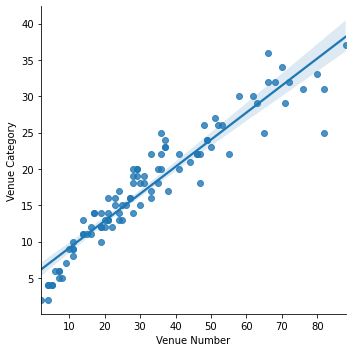

In [9]:

Toronto_venues_grouped_2 = Toronto_venues_refined.groupby(["Neighbourhood","Venue Category"]).count().reset_index()
Toronto_venues_grouped_3 = Toronto_venues_grouped_2.groupby(["Neighbourhood"]).count().reset_index()

Toronto_venues_cluster = pd.concat([Toronto_venues_grouped.set_index("Neighbourhood")["Venue"],Toronto_venues_grouped_3.set_index("Neighbourhood")["Venue Category"]], axis = 1) 

Toronto_venues_cluster = Toronto_venues_cluster.rename(columns={"Venue":"Venue Number"})
import seaborn as sns
import matplotlib as plt
g = sns.lmplot(x="Venue Number", y="Venue Category", data=Toronto_venues_cluster)


Conclusion: As seen in the figure, there are increasing diversity with the number of venues in each suburb, which almost show a linear relationship.

## Determine the location of the venue
In this section we gonna:
- check the characteristics of the restaurants in the top 10 areas (the ranking is based on the number of venues in the area)
- Explore the slimilarity between these areas
- Determine the most popular restaurant types in these areas.

In [30]:
# K means clustering
Top_suburbs = Toronto_venues_grouped.sort_values(by = ["Venue"], ascending = False).iloc[0:10,0].to_numpy()
print(Top_suburbs)

['Don Mills' 'Willowdale, Newtonbrook'
 "Milliken, Agincourt North, Steeles East, L'Amoreaux East" 'Agincourt'
 'Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West'
 'The Beaches' 'Canada Post Gateway Processing Centre'
 'Humewood-Cedarvale' 'Alderwood, Long Branch' 'Studio District']


In [32]:
Top_suburbs_venue = pd.DataFrame(columns=Toronto_venues_refined.columns)

for i in list(Top_suburbs):
    Top_suburbs_venue = Top_suburbs_venue.append(Toronto_venues_refined.loc[Toronto_venues_refined["Neighbourhood"] == i,:]) 

In [33]:
# one hot encoding
Top_suburbs_venue_onehot = pd.get_dummies(Top_suburbs_venue[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
Top_suburbs_venue_onehot['Neighbourhood'] = Top_suburbs_venue['Neighbourhood']

# move Neighbourhood column to the first column
fixed_columns = [Top_suburbs_venue_onehot.columns[-1]] + list(Top_suburbs_venue_onehot.columns[:-1])
Top_suburbs_venue_onehot = Top_suburbs_venue_onehot[fixed_columns]

Top_suburbs_venue_onehot.head()

,Neighbourhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hong Kong Restaurant,Hot Dog Joint,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Pakistani Restaurant,Persian Restaurant,Pide Place,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,South American Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
1254,Don Mills,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1255,Don Mills,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1256,Don Mills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1257,Don Mills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1258,Don Mills,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
Top_suburbs_venue_grouped = Top_suburbs_venue_onehot.groupby('Neighbourhood').mean().reset_index()
# check the top 4 venues appeared in each neighbouhood.
num_top_venues = 4

for n in Top_suburbs_venue_grouped['Neighbourhood']:
    print("----"+n+"----")
    temp = Top_suburbs_venue_grouped[Top_suburbs_venue_grouped['Neighbourhood'] == n].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                venue  freq
0  Chinese Restaurant  0.21
1          Restaurant  0.10
2              Bakery  0.06
3         Pizza Place  0.05


----Alderwood, Long Branch----
                  venue  freq
0            Restaurant  0.10
1           Pizza Place  0.10
2  Fast Food Restaurant  0.07
3        Sandwich Place  0.07


----Canada Post Gateway Processing Centre----
                       venue  freq
0                 Restaurant  0.10
1             Sandwich Place  0.07
2  Middle Eastern Restaurant  0.07
3       Fast Food Restaurant  0.06


----Don Mills----
                 venue  freq
0  Japanese Restaurant  0.10
1          Pizza Place  0.09
2           Restaurant  0.08
3                 Café  0.07


----Humewood-Cedarvale----
              venue  freq
0       Pizza Place  0.09
1        Restaurant  0.07
2  Sushi Restaurant  0.06
3            Bakery  0.06


----Milliken, Agincourt North, Steeles East, L'Amoreaux East----
                   venue  freq
0     Chinese 

In [64]:
# Stored in a dataframe format
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
Neighbourhoods_venues_sorted['Neighbourhood'] = Top_suburbs_venue_grouped['Neighbourhood']

for ind in np.arange(Top_suburbs_venue_grouped.shape[0]):
    Neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Top_suburbs_venue_grouped.iloc[ind, :], num_top_venues)

Neighbourhoods_venues_sorted.head()


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Agincourt,Chinese Restaurant,Restaurant,Bakery,Pizza Place
1,"Alderwood, Long Branch",Pizza Place,Restaurant,Fast Food Restaurant,Sandwich Place
2,Canada Post Gateway Processing Centre,Restaurant,Middle Eastern Restaurant,Sandwich Place,Chinese Restaurant
3,Don Mills,Japanese Restaurant,Pizza Place,Restaurant,Café
4,Humewood-Cedarvale,Pizza Place,Restaurant,Italian Restaurant,Sushi Restaurant


In [65]:
# K-means clustering

# set number of clusters
kclusters = 3

Top_suburbs_venue_grouped_clustering = Top_suburbs_venue_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Top_suburbs_venue_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])

# add clustering labels
Neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


Top_suburbs_venue_merged = df

# merge Toronto_grouped with Toronto_data to add latitude/longitude for each Neighbourhood
Top_suburbs_venue_merged = Top_suburbs_venue_merged.join(Neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how = 'inner')


Top_suburbs_venue_merged.to_csv("Top_venue_result.csv")
Top_suburbs_venue_merged.head()

[2 0 0 0 0 2 0 0 0 1]


,Unnamed: 0,Postal Code,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
12,12,M1S,Agincourt,Scarborough,43.794200,-79.262029,2,Chinese Restaurant,Restaurant,Bakery,Pizza Place
14,14,M1V,"Milliken, Agincourt North, Steeles East, L'Amo...",Scarborough,43.815252,-79.284577,2,Chinese Restaurant,BBQ Joint,Japanese Restaurant,Korean Restaurant
21,21,M2M,"Willowdale, Newtonbrook",North York,43.789053,-79.408493,1,Korean Restaurant,Middle Eastern Restaurant,Restaurant,Café
26,26,M3B,Don Mills,North York,43.745906,-79.352188,0,Japanese Restaurant,Pizza Place,Restaurant,Café
27,27,M3C,Don Mills,North York,43.725900,-79.340923,0,Japanese Restaurant,Pizza Place,Restaurant,Café


## Conlusion
We have used three clusters to categorise ten neighbourhoods with the highest number of restaurants. The K-means result shows that:
- Category 1: In Scaborough region, the Chinese restaurants are the most common ones.
- Category 2: In Willowdale and Newtonbrook region, Korean and Middle Eastern restaurants are the most common ones.
- Category 3: In other seven regions, pizza place sounds like a more common business